### 1. 구글 드라이브 마운트

구글 코랩 환경에서 구글 드라이브를 연결하기 위한 코드입니다. 이를 통해 드라이브 내의 파일에 접근할 수 있으며, 여기서는 신용카드 거래 데이터를 사용합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 2. 데이터 로딩 및 전처리
데이터를 로드하고 전처리하는 과정입니다. `pandas`를 사용해 CSV 파일을 읽고, 필요한 피처와 라벨을 분리합니다. 이후, 데이터를 트레이닝 세트와 테스트 세트로 나누고, `StandardScaler`를 이용해 데이터를 스케일링합니다. 이는 모델의 성능을 향상시키기 위한 필수적인 단계입니다.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
data = pd.read_csv('creditcard.csv')

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. 딥러닝 모델 생성 및 훈련
`tensorflow`와 `keras`를 사용하여 딥러닝 모델을 구성하고 컴파일하는 과정입니다. 여기서는 다층 퍼셉트론 모델을 구성하고, 이진 분류를 수행합니다. `ModelCheckpoint` 콜백을 사용하여 최적의 모델을 저장합니다. 모델의 성능을 평가하기 위해 정확도, 정밀도, 재현율을 메트릭으로 사용합니다.


In [7]:
# 필요 라이브러리 import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint 콜백 생성
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# 모델 생성
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(),Recall()])

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20


c:\Users\qq\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14241/14241 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9978 - loss: 0.0140 - precision: 0.6076 - recall: 0.6321 - val_accuracy: 0.9993 - val_loss: 0.0038 - val_precision: 0.8041 - val_recall: 0.7959
Epoch 2/20
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9994 - loss: 0.0036 - precision: 0.8390 - recall: 0.7687 - val_accuracy: 0.9993 - val_loss: 0.0035 - val_precision: 0.8333 - val_recall: 0.7653
Epoch 3/20
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9994 - loss: 0.0030 - precision: 0.8667 - recall: 0.7825 - val_accuracy: 0.9993 - val_loss: 0.0033 - val_precision: 0.8372 - val_recall: 0.7347
Epoch 4/20
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9995 - loss: 0.0023 - precision: 0.8912 - recall: 0.8199 - val_accuracy: 0.9994 - val_loss: 0.0036 - val_precision: 0.8621 - val_recall: 0.7653
Epoch 5/20
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9994 - loss: 0.0027 - precision: 0.9145 - recall: 0.7638 - val_accuracy: 0.9994 

### 4. 모델 성능 평가
모델의 예측 결과를 실제 라벨과 비교하여 성능을 평가하는 과정입니다. `classification_report`를 사용하여 각 클래스별 정밀도, 재현율, f1-점수 등을 출력합니다. 이는 모델의 세부 성능을 이해하는 데 도움을 줍니다.


In [8]:
# classification_report import
from sklearn.metrics import classification_report

# 예측 라벨 구하기. predicted 구한 후, 값이  0.5초과면 1, 0.5이하면 0으로 반환
actual = y_test
predicted = model.predict(X_test)
predicted_labels = (predicted > 0.5).astype(int)

# classification_report 출력
report = classification_report(actual, predicted_labels, target_names=['Normal', 'Fraud'])
print(report)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.85      0.79      0.81        98

    accuracy                           1.00     56962
   macro avg       0.92      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



### 5. 혼동 행렬 시각화
혼동 행렬을 계산하고 시각화하는 과정입니다. `matplotlib`와 `seaborn` 라이브러리를 사용하여 혼동 행렬을 그래프로 나타냅니다. 이를 통해 모델이 어떤 클래스를 어떻게 잘못 분류했는지 직관적으로 이해할 수 있습니다.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


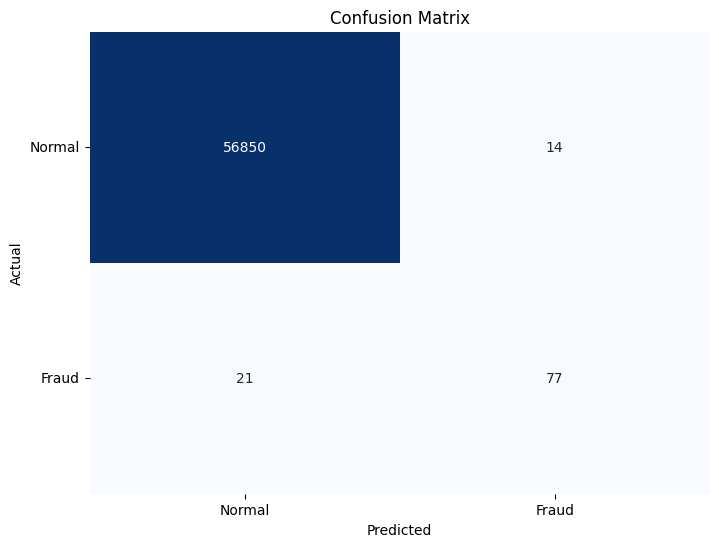

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# confusion matrix import
actual = y_test
predicted = model.predict(X_test)
predicted_labels = (predicted > 0.5).astype(int)

# 혼동 행렬 계산
cm = confusion_matrix(actual, predicted_labels)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Fraud'])
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Fraud'], rotation=0)
plt.title('Confusion Matrix')
plt.show()

### ROC 곡선 및 AUC 그리기
ROC 곡선과 AUC(Area Under the Curve)를 계산하고 그리는 과정입니다. 이는 모델의 전반적인 성능을 나타내며, 모델이 얼마나 잘 또는 나쁘게 예측하는지를 시각적으로 표현합니다.

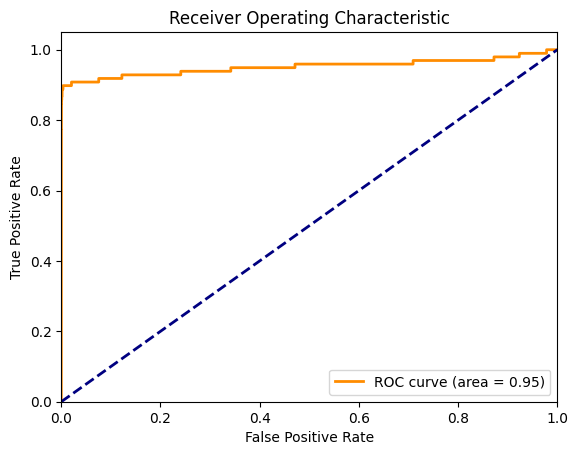

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ROC 곡선 데이터 계산
fpr, tpr, thresholds = roc_curve(actual, predicted)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()